In [1]:
COLAB_FLAG = False   # whether running on colab or locally on computer

In [2]:
if COLAB_FLAG:
    %pip install pydicom==2.1.2
    %pip install monai seaborn sentence_transformers
    %git clone 'redacted name of repo here'




In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
import scipy.stats as stats

warnings.filterwarnings("ignore")

/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/AIPI540_individual_project/scripts/')
    train_datafile = '/content/AIPI540_individual_project/data/trainfiles.csv'
    val_datafile = '/content/AIPI540_individual_project/data/valfiles.csv'
    test_datafile = '/content/AIPI540_individual_project/data/testfiles.csv'

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/')
    os.chdir('/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/')
    print(os.getcwd())
    print(sys.path)
    train_datafile = 'data/trainfiles.csv'
    val_datafile = 'data/valfiles.csv'
    test_datafile = 'data/testfiles.csv'

### local imports ###
#from scripts import config
from scripts.config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from scripts.config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from scripts.config import sentence_encoder, series_description_column
from scripts.utils import *

from scripts.NLP.NLP_training import train_NLP_model
from scripts.NLP.NLP_inference import get_NLP_inference
from scripts.cnn.cnn_dataset import ImgDataset
from scripts.cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from scripts.cnn.cnn_model import CustomResNet50
from scripts.cnn.cnn_data_loaders import get_data_loaders
from scripts.metadata.meta_inference import meta_inference, calc_feature_importances
from scripts.metadata.meta_training import train_fit_parameter_trial, train_meta_model, evaluate_meta_model
from scripts.fusion_model.fus_model import FusionModel
from scripts.fusion_model.fus_inference import get_fusion_inference, get_fusion_inference_from_file
from scripts.fusion_model.fus_training import train_fusion_model, CustomDataset
from scripts.model_container import ModelContainer
from scripts.process_tree import Processor


/Users/cmm/Documents/GitHub/new/AIPI540_individual_project
['/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/notebooks', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python311.zip', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11/lib-dynload', '', '/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11/site-packages', '/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/']


# Load Datasets


In [5]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile)
#test_df

In [6]:
# prepares the features (preprocess normalizes/binarizes/ordinalizes the columns and limits to the feature set) and gets the labels

X_train_meta, scaler = preprocess(train_df, need_fit_scaler=True, save_scaler=True)

X_val_meta, _ = preprocess(val_df, scaler)
X_test_meta, _ = preprocess(test_df, scaler)
y_train = train_df.label
y_val = val_df.label
y_test = test_df.label


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


## Get Inferences from Saved Models

In [7]:
# Load the pickled model
with open(model_paths['meta'], 'rb') as file:
    meta_model = pickle.load(file)

with open(model_paths['scaler'], 'rb') as file:
    scaler = pickle.load(file)



In [8]:
# gets predictions, probabilitie, the truth label, and accuracies for the training, validation, and test datasets

Tpreds, Tprobs, Ty, Tacc = meta_inference(train_df, scaler, meta_model, feats_to_keep)
Vpreds, Vprobs, Vy, Vacc = meta_inference(val_df, scaler, meta_model, feats_to_keep)
TEpreds, TEprobs, TEy, TEacc = meta_inference(test_df, scaler, meta_model, feats_to_keep)


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.


Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


In [9]:
# create dataframes from the data above

meta_train_results_df = make_results_df(Tpreds, Tprobs, Ty, train_df)
meta_val_results_df = make_results_df(Vpreds, Vprobs, Vy, val_df)
meta_test_results_df = make_results_df(TEpreds, TEprobs, TEy, test_df)
meta_vector = Tprobs

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.77      0.93      0.84        61
       dynamic_late       0.94      0.94      0.94        17
             t2 cor       0.96      1.00      0.98        22
                dwi       1.00      1.00      1.00        43
              t2 ax       0.98      1.00      0.99        42
          dixon_fat       0.89      0.83      0.86        29
   hepatobiliary ax       0.67      0.60      0.63        10
  hepatobiliary cor       1.00      0.67      0.80         3
        in_phase ax       1.00      1.00      1.00        23
dynamic_equilibrium       0.60      0.27      0.37        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      0.93      0.96        28
   opposed_phase ax       0.66      0.91      0.76        23
      portal_venous       0.44      0.35      0.39        20
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

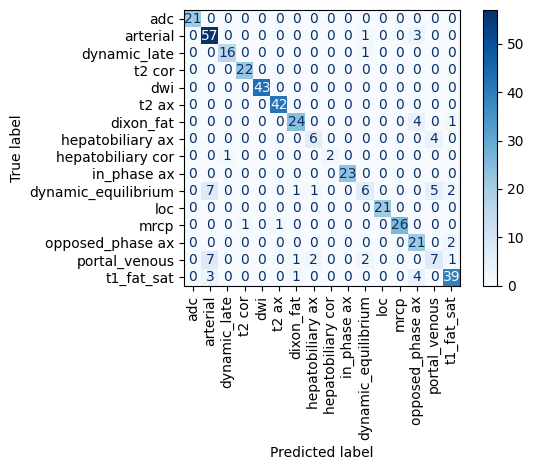

In [10]:
metadata_results = display_and_save_results2(meta_test_results_df.preds, meta_test_results_df.true, fn='meta', saveflag=False)

In [11]:
# for metadata model only
meta_acc_int, meta_f1_int, meta_f1_overall_int, acc_list, f1_list = bootstrap_results(meta_test_results_df, 'preds', 'true')


overall_f1_scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [12]:

# image based models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pix = CustomResNet50(19)

# Load the saved state dictionary
saved_state_dict = torch.load('models/pixel_model_041623.pth', map_location=device)

# Modify the keys to add the 'resnet50.' prefix
modified_state_dict = {f'resnet50.{k}': v for k, v in saved_state_dict.items()}

# Load the modified state dictionary into the current model
model_pix.load_state_dict(modified_state_dict)
model_pix = model_pix.to(device)


In [13]:
# get the inference results on the ResNet50 pixel-based model

#pixel_train_preds, pixel_train_probs = pixel_inference(model_pix, train_df.fname.tolist())
#pixel_val_preds, pixel_val_probs = pixel_inference(model_pix, val_df.fname.to_list())
pixel_test_preds, pixel_test_probs = pixel_inference(model_pix, test_df.fname.to_list())

In [14]:
# put the inference results into a dataframe

#pixel_train_results_df = make_results_df(pixel_train_preds, pixel_train_probs, Ty, train_df)
#pixel_val_results_df = make_results_df(pixel_val_preds, pixel_val_probs, Vy, val_df)
pixel_test_results_df = make_results_df(pixel_test_preds, pixel_test_probs, TEy, test_df)


                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.82      0.84      0.83        61
       dynamic_late       0.89      1.00      0.94        17
             t2 cor       1.00      1.00      1.00        22
                dwi       1.00      1.00      1.00        43
              t2 ax       1.00      0.98      0.99        42
          dixon_fat       1.00      1.00      1.00        29
   hepatobiliary ax       0.00      0.00      0.00        10
  hepatobiliary cor       1.00      0.33      0.50         3
        in_phase ax       1.00      0.83      0.90        23
dynamic_equilibrium       0.57      0.36      0.44        22
                loc       1.00      0.95      0.98        21
               mrcp       1.00      1.00      1.00        28
   opposed_phase ax       0.81      0.96      0.88        23
      portal_venous       0.43      0.75      0.55        20
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

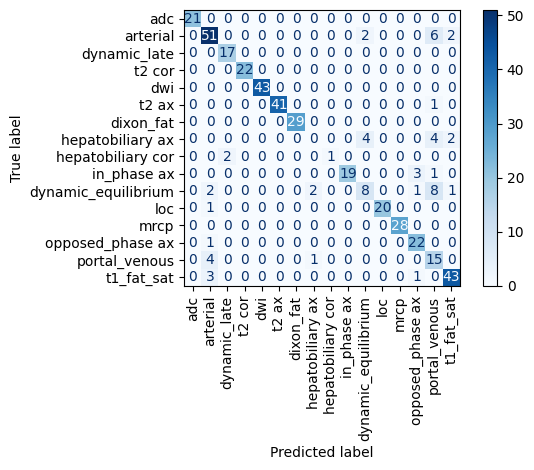

In [15]:
resnet50_results = display_and_save_results2(pixel_test_results_df.preds, pixel_test_results_df.true, fn='pixel', saveflag=False)

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.93      0.84      0.88        61
       dynamic_late       0.85      1.00      0.92        17
             t2 cor       0.95      0.95      0.95        22
                dwi       0.93      1.00      0.97        43
              t2 ax       1.00      0.93      0.96        42
          dixon_fat       1.00      1.00      1.00        29
   hepatobiliary ax       0.50      0.10      0.17        10
  hepatobiliary cor       0.00      0.00      0.00         3
        in_phase ax       0.96      0.96      0.96        23
dynamic_equilibrium       0.56      0.82      0.67        22
                loc       0.95      0.95      0.95        21
               mrcp       1.00      0.96      0.98        28
   opposed_phase ax       0.96      1.00      0.98        23
      portal_venous       0.60      0.75      0.67        20
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

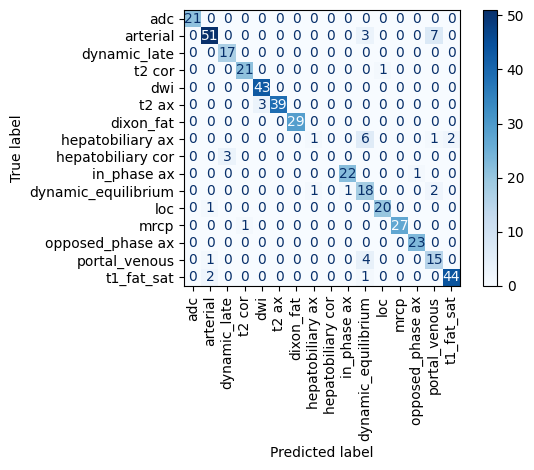

In [16]:

# now getting inference for the trained DenseNet121 model

model_dense = load_pixel_model('models/DenseNet_model.pth', model_type='DenseNet')
model_dense.to(device)
dense_test_preds, dense_test_probs = pixel_inference(model_dense, test_df.fname.to_list())
dense_test_results_df = make_results_df(dense_test_preds, pixel_test_probs, TEy, test_df)
densenet_results = display_and_save_results2(dense_test_results_df.preds, dense_test_results_df.true, fn='dense', saveflag=False)

In [17]:
dense_acc_int, dense_f1_int, dense_f1_overall_int, dense_acc_list, dense_f1_list = bootstrap_results(dense_test_results_df, 'preds', 'true')


overall_f1_scores: [0.9714285714285714, 1.0, 0.9615384615384615, 0.9615384615384615, 1.0, 0.9777777777777777, 0.9767441860465117, 0.9473684210526316, 0.9545454545454545, 0.9302325581395349, 0.9743589743589743, 0.9444444444444444, 0.9705882352941176, 0.9583333333333334, 1.0, 0.9411764705882353, 0.9259259259259259, 0.962962962962963, 0.9795918367346939, 1.0, 1.0, 0.9714285714285714, 0.9361702127659575, 0.9600000000000001, 0.9777777777777777, 0.967741935483871, 1.0, 0.9696969696969697, 0.9375, 0.9411764705882353, 0.9743589743589743, 1.0, 0.962962962962963, 0.888888888888889, 0.923076923076923, 0.9473684210526316, 0.9803921568627451, 0.975609756097561, 0.9795918367346939, 0.9767441860465117, 0.9787234042553191, 0.962962962962963, 0.9545454545454545, 0.9696969696969697, 0.972972972972973, 0.9600000000000001, 0.8571428571428571, 0.9600000000000001, 0.9795918367346939, 0.975609756097561, 0.9811320754716981, 0.9705882352941176, 0.9545454545454545, 0.9787234042553191, 0.9777777777777777, 0.9090

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.93      0.90      0.92        61
       dynamic_late       0.89      1.00      0.94        17
             t2 cor       1.00      1.00      1.00        22
                dwi       1.00      1.00      1.00        43
              t2 ax       1.00      1.00      1.00        42
          dixon_fat       1.00      1.00      1.00        29
   hepatobiliary ax       0.50      0.10      0.17        10
  hepatobiliary cor       1.00      0.33      0.50         3
        in_phase ax       0.96      0.96      0.96        23
dynamic_equilibrium       0.58      0.82      0.68        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      1.00      1.00        28
   opposed_phase ax       0.96      1.00      0.98        23
      portal_venous       0.71      0.75      0.73        20
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

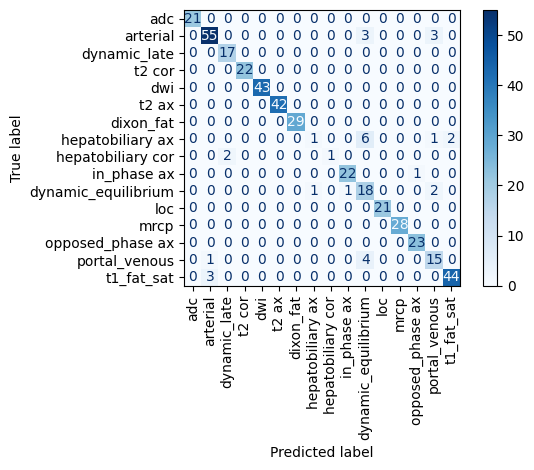

In [18]:
### manually creating the preds and probs for the densenet model data combining for meta<70

dense70_df = dense_test_results_df.copy()
dense70_df['dense_preds'] = dense70_df['preds']
dense70_df = dense70_df.drop('preds', axis=1)
dense70_df = dense70_df.drop('probs', axis=1)
dense70_df = meta_test_results_df.merge(dense70_df, how = 'left', on = ['series', 'patientID'])
dense70_df['meta_confidence'] = dense70_df['probs'].apply(lambda x: max(x))
dense70_df.loc[dense70_df['meta_confidence'] < 0.7, 'preds'] = dense70_df['dense_preds']
dense70_df.preds = dense70_df.preds.astype('int')
densenet70_results = display_and_save_results2(dense70_df.preds, dense70_df.true_x, fn='dense70', saveflag=True)

In [19]:
# for densenet for meta<70
dense70_acc_int, dense70_f1_int, dense70_f1_overall_int, dense70_acc_list, dense70_f1_list = bootstrap_results(dense70_df, 'preds', 'true_x')


overall_f1_scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

### Getting NLP inference


In [20]:
# Load the pickled model
with open('models/text_model20230415.st', 'rb') as file:
    NLP_model = pickle.load(file)

In [21]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
senttrans_model = SentenceTransformer(sentence_encoder, device=device)



In [22]:
#from NLP.NLP_training import train_NLP_model
train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, text_model_T = train_NLP_model(train_df, val_df, test_df, senttrans_model=senttrans_model)
print(train_acc, val_acc, test_acc)

Accuracy on the training set is 0.953
size of preds_val is  354
Accuracy on the val set is 0.960
Accuracy on the test set is 0.963
0.9525200876552228 0.96045197740113 0.9629629629629629


In [23]:

nlp_test_preds, nlp_test_probs = get_NLP_inference(NLP_model, test_df.fname.tolist())
# #nlp_train_preds, nlp_train_probs = get_NLP_inference(NLP_model, train_df.fname.tolist())
# #nlp_val_preds, nlp_val_probs = get_NLP_inference(NLP_model, val_df.fname.tolist())


/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_spli

In [24]:
print(classification_report(nlp_test_preds, TEy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.98      0.95      0.97        63
           6       1.00      0.85      0.92        20
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        42
          11       0.86      1.00      0.93        25
          12       0.60      1.00      0.75         6
          13       0.00      0.00      0.00         0
          14       1.00      1.00      1.00        23
          16       1.00      0.81      0.90        27
          17       1.00      1.00      1.00        21
          18       0.96      1.00      0.98        27
          19       1.00      1.00      1.00        23
          23       1.00      0.91      0.95        22
          25       0.94      0.96      0.95        46

    accuracy                           0.96       432
   macro avg       0.90   

In [25]:
# nlp_train_results_df = make_results_df(nlp_train_preds, nlp_train_probs, Ty, train_df)
# nlp_val_results_df = make_results_df(nlp_val_preds, nlp_val_probs, Vy, val_df)
nlp_test_results_df = make_results_df(nlp_test_preds, nlp_test_probs, TEy, test_df)

# #change names of preds, probs
# for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
# #    frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)


## Create fusion model

In [26]:

with open('data/fusion_train.pkl', 'rb') as file:
    ftrain = pd.read_pickle(file)

with open('data/fusion_val.pkl', 'rb') as file:
    fval = pd.read_pickle(file)

with open('data/fusion_test.pkl', 'rb') as file:
    ftest = pd.read_pickle(file)


#adjust the labels to consecutive numbers 0-18 and storing the original labels into 'class'
ftest['class'] = ftest['true']
ftrain['class'] = ftrain['true']
fval['class'] = fval['true']

ftest['true'] = ftest['true'].apply(lambda x: classes.index(x))
ftrain['true'] = ftrain['true'].apply(lambda x: classes.index(x))
fval['true'] = fval['true'].apply(lambda x: classes.index(x))

# get model container for the base models
model_container=ModelContainer()
model_containerDense = ModelContainer()
model_containerDense.cnn_model = model_dense

#  Instantiate FusionModel
fusion_model = FusionModel(model_containerDense, pretrained=False)
fusion_model_no_nlp = FusionModel(model_containerDense, pretrained=False, include_nlp=False)


# Define the loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=0.001)
p_optimizer = optim.Adam(fusion_model_no_nlp.parameters(), lr=0.001)


train_dataset = CustomDataset(ftrain)
val_dataset = CustomDataset(fval)
test_dataset = CustomDataset(ftest)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)




In [27]:
# Loading trained fusion model to get predictions
# Instantiating models

Fmodel = FusionModel(model_containerDense)
Fmodel_no_nlp = FusionModel(model_containerDense, include_nlp=False)

# Load the saved state_dict (model weights)
saved_model_weights = torch.load('models/fusion_model_weightsDense20230919.pth')
saved_model_weights_no_nlp = torch.load('models/fusion_model_weights_no_nlpDense20230919.pth')

# Load the state_dict into the model
Fmodel.load_state_dict(saved_model_weights)
Fmodel_no_nlp.load_state_dict(saved_model_weights_no_nlp)


<All keys matched successfully>

In [28]:



def compare_fusion_models(data, y_true, fus_model1, fus_model2):

    # Set the model to evaluation mode
    fus_model1.eval()
    fus_model2.eval()


    predictions1 = []
    probs1 = []

    predictions2 = []
    probs2 = []


    for index, row in data.iterrows():
        pred1, prob1, ts_df1 = fus_model1.get_fusion_inference(row)
        predictions1.append(pred1)
        probs1.append(prob1)


        pred2, prob2, ts_df2 = fus_model2.get_fusion_inference(row)
        predictions2.append(pred2)
        probs2.append(prob2)

    comparison_fusion_df = pd.DataFrame({'preds': predictions1, 'probs': probs1, 'preds2': predictions2, 'probs2': probs2, 'true': TEy})
    accuracy1 = np.mean(comparison_fusion_df.preds==comparison_fusion_df.true)
    accuracy2 = np.mean(comparison_fusion_df.preds2== comparison_fusion_df.true)

    print('The accuracies of models 1 and 2 are: ', np.round(accuracy1,3), np.round(accuracy2,3))


    return comparison_fusion_df, accuracy1, accuracy2, predictions1, predictions2


In [29]:
# comparison_df, acc1, acc2, pred1, pred2 = compare_fusion_models(X_test_meta, TEy, Fmodel, Fmodel_no_nlp)

In [30]:
# ### getting results for the nlp fusion test for display
# fusion_results_df = dense_test_results_df.copy()
# fusion_results_df['fusion_preds'] = comparison_df['preds2'].values
# fusion_ = display_and_save_results(fusion_results_df.fusion_preds, fusion_results_df.true, fn='fusion_no_nlp', saveflag=False)


In [32]:
## now testing out the heuristic version incorporated into fus_inference.py 

h_preds = []
h_probs = []

for index, row in X_test_meta.iterrows():
    h_pred, h_prob, h_ts_df1 = Fmodel.get_fusion_inference(row, use_heuristic=True)
    h_preds.append(h_pred)
    
    h_probs.append(h_prob)


heuristic_df = pd.DataFrame({'preds': h_preds, 'probs': h_probs, 'true': TEy})
h_accuracy = np.mean(heuristic_df.preds==heuristic_df.true)

print(h_accuracy)

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_spli